<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/Object_Detection/RetinaNet(2017).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 코드 출처
- https://github.com/kuangliu/pytorch-retinanet

In [ ]:
from torchvision.datasets import VOCDetection
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from PIL import Image, ImageDraw, ImageFont
import os
import xml.etree.ElementTree as ET
from typing import Any, Callable, Dict, Optional, Tuple, List
import warnings
import tarfile
import collections
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Dataset 불러오기

In [ ]:
path2data = '/content/voc'
if not os.path.exists(path2data):
    os.mkdir(path2data)

In [ ]:

# VOC class names
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

In [ ]:
# PyTorch에서 제공하는 VOC dataset class를 수정하여 사용합니다.
class myVOCDetection(VOCDetection):
    def __getitem__(self, index):
        img = np.array(Image.open(self.images[index]).convert('RGB'))
        target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot()) # xml파일 분석하여 dict으로 받아오기

        targets = []
        # class와 바운딩 박스 정보 받아오기
        for t in target['annotation']['object']:
            label = np.zeros(5)
            label[:] = classes.index(t['name']), t['bndbox']['xmin'], t['bndbox']['ymin'], t['bndbox']['xmax'], t['bndbox']['ymax']
            targets.append(label)

        if self.transforms is not None:
            img, target = self.transforms(img, targets)

        return img, targets

    def parse_voc_xml(self, node: ET.Element) -> Dict[str, Any]: # xml 파일을 dictionary로 반환
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

In [ ]:
# train, validation dataset 생성.
train_ds = myVOCDetection(path2data, year='2007', image_set='train', download=True)
val_ds = myVOCDetection(path2data, year='2007', image_set='test', download=True)


Extracting /content/voc/VOCtrainval_06-Nov-2007.tar to /content/voc



Extracting /content/voc/VOCtest_06-Nov-2007.tar to /content/voc


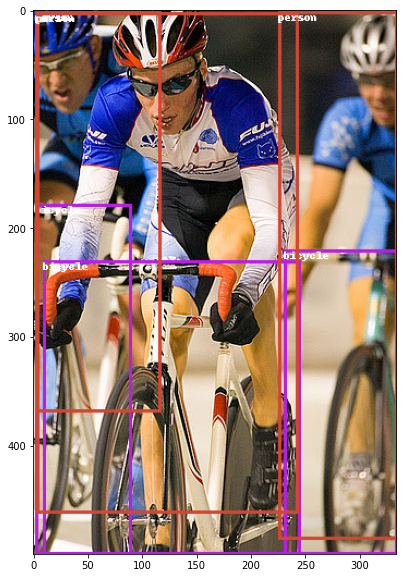

In [ ]:
# 샘플 이미지 확인
img, target = train_ds[2] # img: np.array, target: class, x1, y1, x2, y2

colors = np.random.randint(0, 255, size=(80,3), dtype='uint8') # 바운딩 박스 컬러
def show(img, targets, classes=classes): # 시각화 함수
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)
    W, H = img.size

    for tg in target:
        id_ = int(tg[0])
        bbox = tg[1:5]

        color = [int(c) for c in colors[id_]]
        name = classes[id_]

        draw.rectangle(((bbox[0], bbox[1]), (bbox[2], bbox[3])), outline=tuple(color), width=3)
        draw.text((bbox[0], bbox[1]), name, fill=(255,255,255,0))
    plt.imshow(np.array(img))
plt.figure(figsize=(10,10))
show(img, target)

In [ ]:
print(target)
print(type(img))

[array([  1.,   9., 230., 245., 500.]), array([  1., 230., 220., 334., 500.]), array([  1.,   2., 178.,  90., 500.]), array([ 14.,   2.,   1., 117., 369.]), array([ 14.,   3.,   2., 243., 462.]), array([ 14., 225.,   1., 334., 486.])]
<class 'numpy.ndarray'>


# 2. augmentation 적용하기

# 3. 모델 구축하기
- RetinaNet은 ResNet + FPN 구조를 갖습니다.
- ResNet을 구현할 때, PyTorch 공식 홈페이지 ResNet 모델과 변수 명이 같아야 pre-trained model을 불러올 수 있습니다.
- https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html#resnext50_32x4d

In [ ]:
# BottleNeck of ResNet
class Bottleneck(nn.Module):
    expand = 4

    def __init__(self, in_channels, inner_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(inner_channels)
        self.conv2 = nn.Conv2d(inner_channels, inner_channels, 3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(inner_channels)
        self.conv3 = nn.Conv2d(inner_channels, inner_channels*self.expand, 1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(inner_channels*self.expand)
        self.relu = nn.ReLU()

        self.downsample = nn.Sequential()

        if stride != 1 or in_channels != inner_channels*self.expand:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, inner_channels*self.expand, 1, stride=stride, bias=False),
                nn.BatchNorm2d(inner_channels*self.expand)
            )

        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.relu(self.bn1(self.conv1(x)))
        output = self.relu(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))
        output = self.relu(output + self.downsample(x))

        return output

# check
def test():
    x = torch.randn(1, 56,13,13)
    net = Bottleneck(x.size(1), x.size(1))
    output = net(x)
    print(output.size())

test()

torch.Size([1, 224, 13, 13])


In [ ]:
# FPN 이미지에서 특징을 추출합니다.
class FPN(nn.Module):
    def __init__(self, num_blocks):
        super(FPN, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        # Bottom-up layers and ResNet
        # PyTorch 공식 홈페이지 ResNet 구현 코드와 변수명이 동일해야, pre-trained model을 불러와서 사용할 수 있습니다.
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)  # c2
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)  # c3
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2) # c4
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2) # c5
        self.conv6 = nn.Conv2d(2048, 256, 3, stride=2, padding=1)    # p6
        self.conv7 = nn.Sequential(                                  # p7
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2, padding=1)
        )

        # Lateral layers
        self.lateral_1 = nn.Conv2d(2048, 256, 1, stride=1, padding=0)
        self.lateral_2 = nn.Conv2d(1024, 256, 1, stride=1, padding=0)
        self.lateral_3 = nn.Conv2d(512, 256, 1, stride=1, padding=0)

        # Top-down layers
        self.top_down_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.top_down_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Feature extractor
        c1 = self.relu(self.bn1(self.conv1(x)))
        c1 = self.maxpool(c1)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        # FPN
        p6 = self.conv6(c5)
        p7 = self.conv7(p6)
        p5 = self.lateral_1(c5)
        p4 = self.top_down_1(self.upsample(p5) + self.lateral_2(c4))
        p3 = self.top_down_2(self.upsample(p4) + self.lateral_3(c3))

        return p3, p4, p5, p6, p7

    def _make_layer(self, inner_channels, num_block, stride):
        strides = [stride] + [1] * (num_block-1)
        layers = []
        for stride in strides:
            layers.append(Bottleneck(self.in_channels, inner_channels, stride=stride))
            self.in_channels = inner_channels*Bottleneck.expand
        return nn.Sequential(*layers)

def FPN50():
    return FPN([3,4,6,3])

# check
if __name__ == '__main__':
    x = torch.randn(3, 3, 224, 224)
    model = FPN50()
    outputs = model(x)
    for output in outputs:
        print(output.size())

torch.Size([3, 256, 28, 28])
torch.Size([3, 256, 14, 14])
torch.Size([3, 256, 7, 7])
torch.Size([3, 256, 4, 4])
torch.Size([3, 256, 2, 2])


In [ ]:
# FPN 출력값을 입력으로 받아 바운딩 박스의 좌표 클래스 예측을 수행합니다.
class RetinaNet(nn.Module):
    num_anchors = 9

    def __init__(self, num_classes=20):
        super().__init__()
        self.fpn = FPN50()
        self.num_classes = num_classes
        self.loc_head = self._make_head(self.num_anchors*4) # 바운딩 박스 좌표 예측
        self.cls_head = self._make_head(self.num_anchors*self.num_classes) # 바운딩 박스 클래스 예측

    def forward(self, x):
        # p3: batch, channels, H, W
        fms = self.fpn(x) # p3, p4, p5, p6, p7
        loc_preds = []
        cls_preds = []
        for fm in fms:
            loc_pred = self.loc_head(fm)
            cls_pred = self.cls_head(fm)
            loc_pred = loc_pred.permute(0,2,3,1).contiguous().view(x.size(0),-1,4)  # [N, 9*4,H,W] -> [N,H,W, 9*4] -> [N,H*W*9, 4]
            cls_pred = cls_pred.permute(0,2,3,1).contiguous().view(x.size(0),-1,self.num_classes) # [N,9*20,H,W] -> [N,H,W,9*20] -> [N,H*W*9,20]
            loc_preds.append(loc_pred)
            cls_preds.append(cls_pred)
        return torch.cat(loc_preds,1), torch.cat(cls_preds,1)

    def _make_head(self, out_channels): # 예측을 수행하는 Layer 생성
        layers = []
        for _ in range(4):
            layers.append(nn.Conv2d(256,256,3, stride=1, padding=1))
            layers.append(nn.ReLU())
        layers.append(nn.Conv2d(256, out_channels, 3, stride=1, padding=1)) # (batch,9*4,H,W) or (batch,9*20,H,W) 
        return nn.Sequential(*layers)

    def freeze_bn(self): # pre-trained model을 사용하므로, BN freeze
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

# check
if __name__ == '__main__':
    x = torch.randn(10,3,224,224)
    model = RetinaNet()
    loc_preds, cls_preds = model(x)
    print(loc_preds.size()) # (batch, 5 * H*W * 9, 4)
    print(cls_preds.size()) # (batch, 5 * H*W * 9, 20)

torch.Size([10, 9441, 4])
torch.Size([10, 9441, 20])


In [ ]:
# 사전 학습된 ResNet50의 가중치 다운로드 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
!wget 'https://download.pytorch.org/models/resnet50-19c8e357.pth'

--2021-04-22 13:47:46--  https://download.pytorch.org/models/resnet50-19c8e357.pth
Resolving download.pytorch.org (download.pytorch.org)... 13.35.24.68, 13.35.24.42, 13.35.24.56, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.24.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102502400 (98M) [application/octet-stream]
Saving to: ‘resnet50-19c8e357.pth.1’

resnet50-19c8e357.p 100%[===================>]  97.75M   186MB/s    in 0.5s    

2021-04-22 13:47:47 (186 MB/s) - ‘resnet50-19c8e357.pth.1’ saved [102502400/102502400]



In [ ]:
# FPN의 ResNet50 구조에 사전 학습된 가중치를 적용합니다.
path2weight = '/content/resnet50-19c8e357.pth'
d = torch.load(path2weight)
fpn = FPN50()
dd = fpn.state_dict()
for k in d.keys():
    if not k.startswith('fc'):
        dd[k] = d[k]

model = RetinaNet()
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        init.normal_(m.weight, mean=0, std=0.01)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()

pi = 0.01
init.constant_(model.cls_head[-1].bias, -math.log((1-pi)/pi))

model.fpn.load_state_dict(dd)
torch.save(model.state_dict(), 'model.pth')

# 3. 손실 함수 정의하기

In [ ]:
# labels를 one-hot 형식으로 변경합니다.
def one_hot_embedding(labels, num_classes):
    # labels: class labels, sized [N,]
    # num_classes: 클래스 수
    y = torch.eye(num_classes) # [D, D]
    return y[labels]

